In [ ]:
# install GraphRicciCurvature package

!pip install GraphRicciCurvature

# import packages

import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter
import numpy as np

from GraphRicciCurvature.FormanRicci import FormanRicci
from GraphRicciCurvature.OllivierRicci import OllivierRicci


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def plot_my_graph(G, pos, ax = None, node_col = "white", 
                  edge_lst = [], edge_col = "lightgrey", edge_lab = {},
                  bbox = None, color_map = "Set3", alpha = 1.0):
    node_options = {
        "font_size": 12, 
        "font_color": "black",
        "node_size": 300, 
        "cmap": plt.get_cmap(color_map),
        "alpha": alpha,
        "edgecolors": "black",
        "linewidths": 0.5,   
        "with_labels": True,
        "edgelist": None
        }
    edge_options = {
        "width": 0.5
        }
    fig = plt.figure(figsize=(15,15))
    nx.draw_networkx (G, pos, node_color = node_col, edge_color = edge_col, **node_options)
    nx.draw_networkx_edges (G, pos, edge_lst, edge_color = edge_col, **edge_options)
    nx.draw_networkx_edge_labels(G, pos, label_pos = 0.5, edge_labels = edge_lab, rotate=False, bbox = bbox)
    plt.gca().margins(0.20)
    plt.show()

In [ ]:
def simple_cycles(G, limit):
    subG = type(G)(G.edges())
    sccs = list(nx.strongly_connected_components(subG))
    while sccs:
        scc = sccs.pop()
        startnode = scc.pop()
        path = [startnode]
        blocked = set()
        blocked.add(startnode)
        stack = [(startnode, list(subG[startnode]))]

        while stack:
            thisnode, nbrs = stack[-1]

            if nbrs and len(path) < limit:
                nextnode = nbrs.pop()
                if nextnode == startnode:
                    yield path[:]
                elif nextnode not in blocked:
                    path.append(nextnode)
                    stack.append((nextnode, list(subG[nextnode])))
                    blocked.add(nextnode)
                    continue
            if not nbrs or len(path) >= limit:
                blocked.remove(thisnode)
                stack.pop()
                path.pop()
        subG.remove_node(startnode)
        H = subG.subgraph(scc)
        sccs.extend(list(nx.strongly_connected_components(H)))

In [ ]:
def fr_curvature (G, ni, nj):
    '''
    computes the Forman-Ricci curvature of a given edge 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j

    Returns
    -------
    frc : int
        Forman Ricci curvature of the edge connecting nodes i and j

    '''
    frc = 4 - G.degree(ni) - G.degree(nj)
    return frc 

In [ ]:
def afr_curvature (G, ni, nj, t_coeff, t_num):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge 
    includes 3-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    m : number of triangles containing the edge between node i and j

    Returns
    -------
    afrc : int
        Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc = 4 - G.degree(ni) - G.degree(nj) + t_coeff * t_num
    return afrc

In [ ]:
def afr4_curvature (G, ni, nj, t_coeff, t_num, q_coeff, q_num):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge, 
    includes 3- and 4-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    t : number of triangles containing the edge between node i and j
    q : number of quadrangles containing the edge between node i and j

    Returns
    -------
    afrc4 : int
        enhanced Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc4 = 4 - G.degree(ni) - G.degree(nj) + t_coeff * t_num + q_coeff * q_num
    return afrc4

In [ ]:
def afr5_curvature (G, ni, nj, t_coeff, t_num, q_coeff, q_num, p_coeff, p_num):
    '''
    computes the Augmented Forman-Ricci curvature of a given edge 
    includes 3-, 4- and 5-cycles in calculation 
    
    Parameters
    ----------
    G : Graph
    ni : node i
    nj : node j
    t : number of triangles containing the edge between node i and j
    q : number of quadrangles containing the edge between node i and j
    p : number of pentagons containing the edge between node i and j

    Returns
    -------
    afrc5 : int
        enhanced Forman Ricci curvature of the edge connecting nodes i and j   
    '''
    afrc5 = 4 - G.degree(ni) - G.degree(nj) + t_coeff * t_num + q_coeff * q_num + p_coeff * p_num
    return afrc5


In [ ]:
def init_edge_attributes(G):
    curv_names = ["frc", "afrc", "afrc4", "afrc5"] 
    for (u,v) in list(G.edges()):
        for i in range(3,6):
            G.edges[u,v][cyc_names[i]] = []
        for cn in curv_names:
            G.edges[u,v][cn] = 0

In [ ]:
def set_edge_attributes_2 (G, ll, i):
    for l in ll:     # für jeden Zyklus in der Liste der Zyklen
        for e1 in range(0, i): 
            if e1 == i-1:
                e2 = 0
            else:
                e2 = e1 + 1
            u = l[e1]
            v = l[e2]
            G.edges[u,v][cyc_names[i]].append(l)

In [ ]:
def get_orc_edge_curvatures (G):          
    # compute the Ollivier-Ricci curvature of the given graph G
    orc = OllivierRicci(G, alpha=0.5, verbose="ERROR")
    orc.compute_ricci_curvature()
    # transfer curvatire values from orc.G to G 
    for (u,v) in list(orc.G.edges()):               # für jede Kante
        G.edges[u,v]["orc"] = orc.G.edges[u,v]["ricciCurvature"]
        # print("ORC: ", orc.G.edges[u,v]["ricciCurvature"], ("  -  G: ",G.edges[u,v]["orc"])

In [ ]:
def get_edge_curvatures (G, t_coeff, q_coeff, p_coeff):            
    for (u,v) in list(G.edges()):               # für jede Kante
        tr = len(G.edges[u,v][cyc_names[3]]) / 2  # geteilt durch 2 wegen gerichtetem Graph und daher immer zwei Permutationen pro Zyklus (1x vorwärts / 1x rückwärts)
        qu = len(G.edges[u,v][cyc_names[4]]) / 2
        pe = len(G.edges[u,v][cyc_names[5]]) / 2
        G.edges[u,v]["frc"] = fr_curvature(G, u, v)        
        G.edges[u,v]["afrc"] = afr_curvature(G, u, v, t_coeff, tr)
        G.edges[u,v]["afrc4"] = afr4_curvature(G, u, v, t_coeff, tr, q_coeff, qu)
        G.edges[u,v]["afrc5"] = afr5_curvature(G, u, v, t_coeff, tr, q_coeff, qu, p_coeff, pe)     

In [ ]:
def show_curv_min_max_values (h_data):
    print("\nMin/Max Curvature values:")
    for k in h_data.keys():
        print(str(k).ljust(8), 
              "{0:<5s} {1:8.4f}".format("Min:", h_data[k]["bin_min"]), "  ",
              "{0:<5s} {1:8.4f}".format("Max:", h_data[k]["bin_max"])
              )
    print()

In [ ]:
def get_bin_width (b_min, b_max, num_bin_lim):
    scaling = 1
    multiplier = 10
    # print("b_min:", b_min, "b_max:", b_max, "num_bin_lim:", num_bin_lim, "scaling:", scaling, "multiplier:", multiplier)
    b_width = (b_max - b_min) // 40 + 1
    if abs(b_max) < 1 and abs(b_min) < 1:
        while (b_max - b_min)/scaling < num_bin_lim / 10:
            scaling /= multiplier    
        b_width = scaling
    return b_width

In [ ]:
def show_histos (h_data, title_str, my_nrows = 2, my_ncols = 3, my_bin_num = 40):
    fig, axes = plt.subplots(nrows=my_nrows, ncols=my_ncols, sharey = True, figsize=(16,10))
    for i,k in enumerate(h_data.keys()):
        r = i // my_ncols
        c = i % my_ncols
        bin_width = get_bin_width(h_data[k]["bin_min"], h_data[k]["bin_max"], my_bin_num)
        axes[r,c].hist(h_data[k]["curv"], bins = np.arange(h_data[k]["bin_min"], h_data[k]["bin_max"] + bin_width, bin_width), edgecolor = "white")
        axes[r,c].set_title(h_data[k]["title"])
        axes[r,c].title.set_size(16)
        axes[r,c].tick_params(axis='both', labelsize=16)
        axes[r,c].grid(visible=True, axis="both")
    fig.suptitle(title_str, size=16)
    plt.show()   

In [ ]:
def show_correlation_coeffs (h_data):
    print("\nCorrelation coefficients:")
    ks = list(h_data.keys())
    for i in range(len(ks)):
        for j in range(i+1, len(ks)):
            s = h_data[ks[i]]["title"] + " / " + h_data[ks[j]]["title"]
            c = np.corrcoef(h_data[ks[i]]["curv"], h_data[ks[j]]["curv"])[1][0]
            print(s.ljust(55,"."), f"{c:8.5f}")
        print()

In [ ]:
def show_curv_data (G, title_str):
    h_data = {"orc":  {"curv": [d["orc"]   for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Ollivier Ricci (OR)"},
              "frc":  {"curv": [d["frc"]   for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Forman Ricci (FR)"},
              "afrc": {"curv": [d["afrc"]  for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"Augm. FR curv. (triangles)"},
              "afrc4":{"curv": [d["afrc4"] for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"AFR curv. (tri/quad)"},
              "afrc5":{"curv": [d["afrc5"] for u,v,d in G.edges.data()], "bin_min":0, "bin_max":0, "title":"AFR curv. (tri/quad/pent)"}
              }
    
    for k in h_data.keys():
        # print("h_data.keys: ", k)
        # h_data[k]["bin_min"] = int(min(h_data[k]["curv"]))
        # h_data[k]["bin_max"] = int(max(h_data[k]["curv"]))
        h_data[k]["bin_min"] = min(h_data[k]["curv"])
        h_data[k]["bin_max"] = max(h_data[k]["curv"])
        
    show_curv_min_max_values (h_data)
    show_histos (h_data, title_str, my_nrows = 2, my_ncols = 3, my_bin_num = 40)
    show_correlation_coeffs(h_data)

In [ ]:
def build_size_list (k, l):
    ll = [k  for i in range(l)]
    return ll

In [ ]:
def build_prob_list (n, p_in, p_out):
    ll = []
    for i in range(n):    
        temp_l = [p_out  for j in range(0,i)] + [p_in] + [p_out  for j in range(i+2,n+1)]
        ll.append(temp_l)
    return ll

In [ ]:
cyc_names = {3:"triangles", 4:"quadrangles", 5:"pentagons"}        


In [ ]:
# ---------------------------------- 
# -------  simple example  ---------
# ---------------------------------- 

     
'''  
edges = [(0,3), (0,4), (3,1), (3,2), (3,4), (1,2), (2,4)]
# edges = [(0,3), (0,4), (3,1), (3,2), (3,4), (1,2), (2,4), (0,5), (5,6), (6,4)]

G = nx.Graph()
G.add_edges_from(edges)
init_edge_attributes(G)

H = G.to_directed()

pos1 = nx.kamada_kawai_layout(H)
plot_my_graph(H, pos1)

cycles = []
for c in simple_cycles(H, 6):
    cycles.append(c) 
    
d = dict()
for i in range(3,6):
    d[i] = [c  for c in cycles  if len(c) == i]
    set_edge_attributes_2(G, d[i], i)
    
get_edge_curvatures(G)
    
'''

'  \nedges = [(0,3), (0,4), (3,1), (3,2), (3,4), (1,2), (2,4)]\n# edges = [(0,3), (0,4), (3,1), (3,2), (3,4), (1,2), (2,4), (0,5), (5,6), (6,4)]\n\nG = nx.Graph()\nG.add_edges_from(edges)\ninit_edge_attributes(G)\n\nH = G.to_directed()\n\npos1 = nx.kamada_kawai_layout(H)\nplot_my_graph(H, pos1)\n\ncycles = []\nfor c in simple_cycles(H, 6):\n    cycles.append(c) \n    \nd = dict()\nfor i in range(3,6):\n    d[i] = [c  for c in cycles  if len(c) == i]\n    set_edge_attributes_2(G, d[i], i)\n    \nget_edge_curvatures(G)\n    \n'

In [ ]:
# --------------------------------
# ----------  SBM  ---------------
# --------------------------------

 
'''
sbm = {"size_per_comm" : 6, "num_of_comm" : 2, "p_in" : 0.70, "p_out" : 0.05}
sizes = build_size_list(sbm["size_per_comm"], sbm["num_of_comm"])
probs = build_prob_list(sbm["num_of_comm"], sbm["p_in"], sbm["p_out"])

G = nx.stochastic_block_model(sizes, probs, seed=0)   
init_edge_attributes(G)
  
H = G.to_directed()

pos1 = nx.kamada_kawai_layout(H)
blocks = [v["block"]  for u,v in H.nodes.data()]
plot_my_graph(H, pos1, node_col = blocks)

t0 = perf_counter()

cycles = []
for c in simple_cycles(H, 6):
    cycles.append(c) 

t1 = perf_counter()
print("Zyklen: ",len(cycles))
print("Zeit: ", t1-t0)

d = dict()
for i in range(3,6):
    d[i] = [c  for c in cycles  if len(c) == i]
    set_edge_attributes_2(G, d[i], i)
    
# t2 = perf_counter()
# print("Zyklen ohne Permutationen: ", len(d[3]) + len(d[4]) + len(d[5]))
# print("Zeit: ", t2-t1)

get_edge_curvatures(G)

'''

'\nsbm = {"size_per_comm" : 6, "num_of_comm" : 2, "p_in" : 0.70, "p_out" : 0.05}\nsizes = build_size_list(sbm["size_per_comm"], sbm["num_of_comm"])\nprobs = build_prob_list(sbm["num_of_comm"], sbm["p_in"], sbm["p_out"])\n\nG = nx.stochastic_block_model(sizes, probs, seed=0)   \ninit_edge_attributes(G)\n  \nH = G.to_directed()\n\npos1 = nx.kamada_kawai_layout(H)\nblocks = [v["block"]  for u,v in H.nodes.data()]\nplot_my_graph(H, pos1, node_col = blocks)\n\nt0 = perf_counter()\n\ncycles = []\nfor c in simple_cycles(H, 6):\n    cycles.append(c) \n\nt1 = perf_counter()\nprint("Zyklen: ",len(cycles))\nprint("Zeit: ", t1-t0)\n\nd = dict()\nfor i in range(3,6):\n    d[i] = [c  for c in cycles  if len(c) == i]\n    set_edge_attributes_2(G, d[i], i)\n    \n# t2 = perf_counter()\n# print("Zyklen ohne Permutationen: ", len(d[3]) + len(d[4]) + len(d[5]))\n# print("Zeit: ", t2-t1)\n\nget_edge_curvatures(G)\n\n'

In [ ]:
# -------------------------------------------------------------------------
# ---------------  SBM with k / l / p_in / p_out variation  ---------------
# -------------------------------------------------------------------------


def calculate_SBM(k, l, p_in, p_out, title_str, t_coeff, q_coeff, p_coeff):
    print("k:",k," l:",l," p_in:",p_in," p_out:",p_out)
    sizes = build_size_list(k, l)
    probs = build_prob_list(l, p_in, p_out)
    
    G = nx.stochastic_block_model(sizes, probs, seed = 0)
    init_edge_attributes(G)
      
    H = G.to_directed()
    
    # pos1 = nx.kamada_kawai_layout(H)
    # blocks = [v["block"]  for u,v in H.nodes.data()]
    # plot_my_graph(H, pos1, node_col = blocks)
    
    t0 = perf_counter()
    cycles = []
    for c in simple_cycles(H, 6):
        cycles.append(c) 
    t1 = perf_counter()
    print("Zyklen: ",len(cycles), " - Zeit: ", t1-t0)
    
    d = dict()
    for i in range(3,6):
        d[i] = [c  for c in cycles  if len(c) == i]
        
        # d[i] = remove_permutations(d[i])
        
        # t2 = perf_counter()
        # print(i, " ohne Permutationen - Zeit: ", t2-t1, " / ", end = "")
        set_edge_attributes_2(G, d[i], i)
        # t3 = perf_counter()
        # print(i, "Edge Attributes - Zeit: ", t3-t2)
        # t1 = t3
        
    get_orc_edge_curvatures (G)
    get_edge_curvatures (G, t_coeff, q_coeff, p_coeff)
    # t4 = perf_counter()
    # print("Curvature - Zeit: ", t4-t3)
    
    show_curv_data (G, title_str)
    # t5 = perf_counter()
    # print("Histos - Zeit: ", t5-t4)

In [ ]:
def calculate_SBMs():
    ll_k = [5,10,15,20]
    k_def = 20
    ll_l = [2,3,4,5]
    l_def = 5
    ll_p_in = [0.6, 0.7, 0.8, 0.9]
    p_in_def = 0.7
    ll_p_out = [0.05, 0.03, 0.02, 0.01]
    p_out_def = 0.05
    for k in ll_k:
        s = "Variation of community size / k = " + str(k) + "\n" + \
            "k=" + str(k) + " l=" + str(l_def) + " p_in:" + str(p_in_def) + " p_out:" + str(p_out_def)
        calculate_SBM(k, l_def, p_in_def, p_out_def, s, 3, 2, 1)
    for l in ll_l:
        s = "Variation of number of communities / l = " + str(l) + "\n" + \
            "k=" + str(k_def) + "  l=" + str(l) +  "  p_in=" + str(p_in_def) + "  p_out=" + str(p_out_def)
        calculate_SBM(k_def, l, p_in_def, p_out_def, s, 3, 2, 1)
    for p_in in ll_p_in:
        s = "Variation of p_in / p_in = " + str(p_in) + "\n" + \
            "k=" + str(k_def) + " l=" + str(l_def) +  " p_in:" + str(p_in) + " p_out:" + str(p_out_def)
        calculate_SBM(k_def, l_def, p_in, p_out_def, s, 3, 2, 1)
    for p_out in ll_p_out:
        s = "Variation of p_out / p_out = " + str(p_out) + "\n" + \
            "k=" + str(k_def) + " l=" + str(l_def) +  " p_in:" + str(p_in_def) + " p_out:" + str(p_out)
        calculate_SBM(k_def, l_def, p_in_def, p_out, s, 3, 2, 1)

In [ ]:
# calculate_SBMs()  

In [ ]:
# ----------------------------------------
# -------  Karate Club graph  ------------
# ----------------------------------------

def calculate_karate_club(title_str):

    G = nx.karate_club_graph()
    init_edge_attributes(G)
    H = G.to_directed()

    pos1 = nx.kamada_kawai_layout(H)
    colors= [0  if v["club"] == "Mr. Hi" else 1  for u,v in H.nodes.data()]
    plot_my_graph(H, pos1, node_col = colors)
    
    cycles = []
    for c in simple_cycles(H, 6):
        cycles.append(c) 
    
    d = dict()
    for i in range(3,6):
        d[i] = [c  for c in cycles  if len(c) == i]
        set_edge_attributes_2(G, d[i], i)
        
    get_orc_edge_curvatures (G)
    get_edge_curvatures (G, 3, 2, 1)    
    show_curv_data (G, title_str)

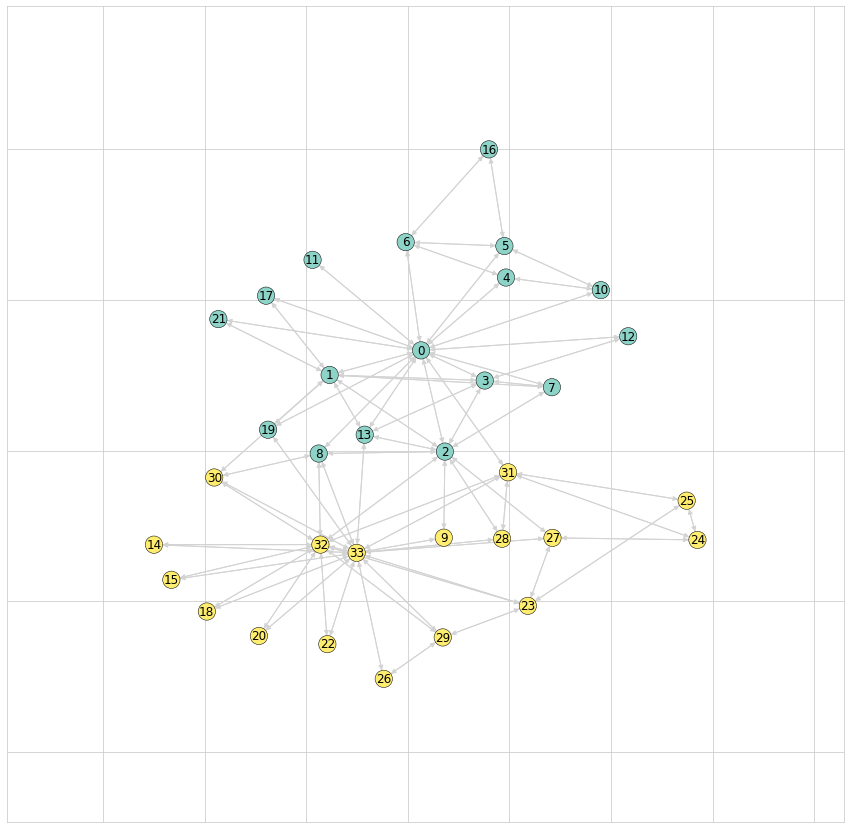


Min/Max Curvature values:
orc      Min:   -0.4271    Max:    0.5000
frc      Min:  -25.0000    Max:   -2.0000
afrc     Min:  -18.0000    Max:    5.0000
afrc4    Min:  -13.0000    Max:   29.0000
afrc5    Min:  -13.0000    Max:   85.0000



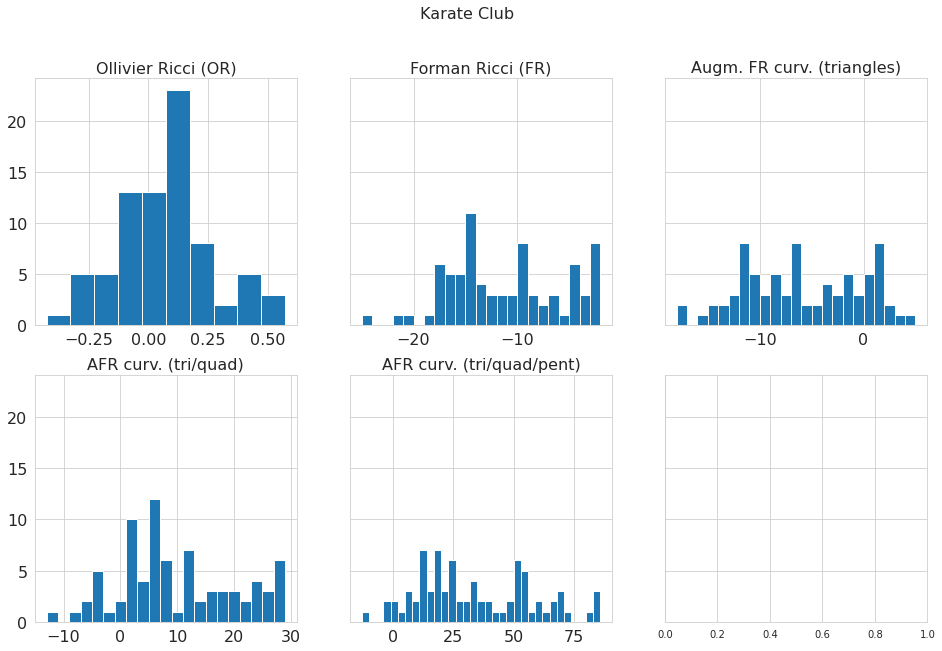


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.70856
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.80825
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.23549
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........ -0.12895

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.61875
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.18270
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.38395

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.46130
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.10747

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.83367




In [ ]:
calculate_karate_club("Karate Club")

In [ ]:
# --------------------------------------------------------
# --------  American Footbal graph -----------------------
# --------------------------------------------------------


def colored_amf_graph(G):
    for n,d in G.nodes.data(): 
        d["color"] = d["value"]
    return G

In [ ]:
def get_circles_in_circle_pos(G, sc, rd, cx, cy, mv, values):
    p = {}
    cnt = np.array([cx, cy])
    for v in values:
        temp = nx.circular_layout(
                    nx.subgraph(G, [n  for n,d in iter(G.nodes.items())  if d["value"] == v]),
                    scale = sc,
                    center = cnt + np.array([rd * np.cos(v/(mv+1)*2*np.pi),
                                             rd * np.sin(v/(mv+1)*2*np.pi)])
                    )
        p.update(temp)
    return p

In [ ]:
# Americal Football (AMF) read-in from football.gml
def calculate_AMF(title_str):
    G = nx.read_gml("football.gml")
    init_edge_attributes(G)
    H = G.to_directed()
    
    values = set([d["value"]  for n,d in iter(G.nodes.items())])
    max_value = list(values)[-1]
    pos_amf = get_circles_in_circle_pos(G, 0.1, 0.6, 0.5, 0.5, max_value, values)
    
    G = colored_amf_graph(G)
    plot_my_graph(G, pos_amf, 
                  node_col = [d["color"]  for n,d in G.nodes.data()],
                  color_map = "tab20", alpha = 0.7)

    cycles = []
    for c in simple_cycles(H, 6):
        cycles.append(c) 
    
    d = dict()
    for i in range(3,6):
        d[i] = [c  for c in cycles  if len(c) == i]
        set_edge_attributes_2(G, d[i], i)
        
    get_orc_edge_curvatures (G)
    get_edge_curvatures (G, 3, 2, 1)    
    show_curv_data (G, title_str)

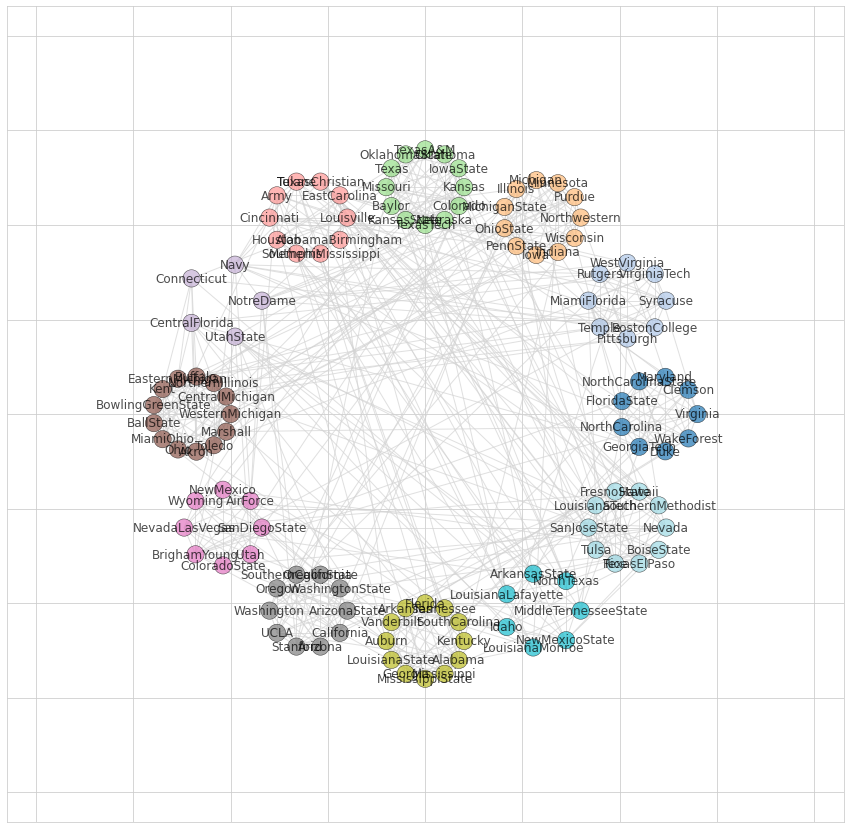


Min/Max Curvature values:
orc      Min:   -0.8182    Max:    0.4136
frc      Min:  -20.0000    Max:  -12.0000
afrc     Min:  -20.0000    Max:    7.0000
afrc4    Min:  -18.0000    Max:   97.0000
afrc5    Min:  -18.0000    Max:  380.0000



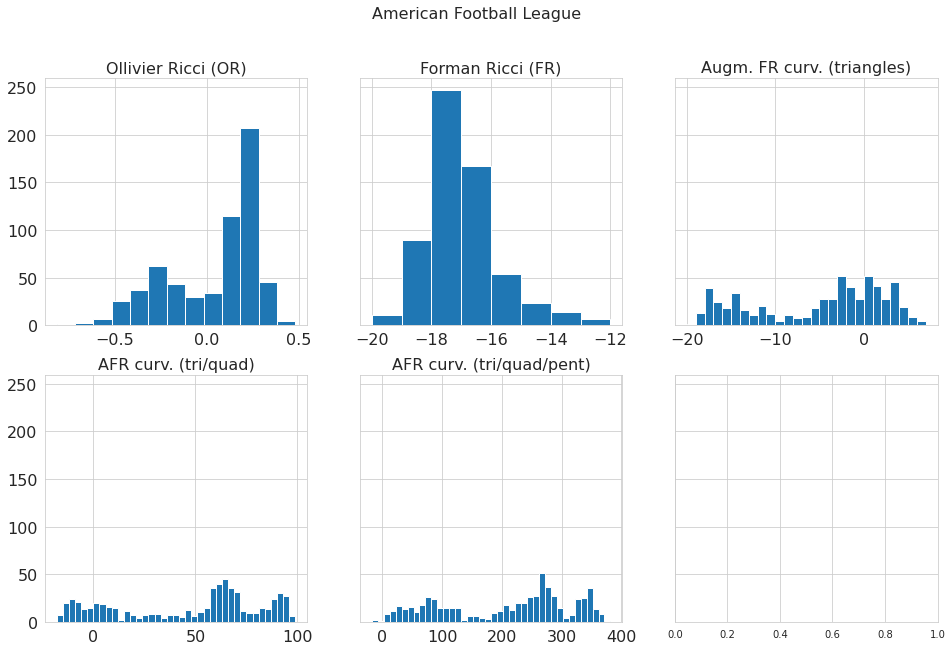


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................ -0.08558
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.92871
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.92638
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.89769

Forman Ricci (FR) / Augm. FR curv. (triangles)......... -0.07394
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.28123
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.35647

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.93965
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.86466

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97736




In [ ]:
calculate_AMF("American Football League")

In [ ]:
# -----------------------------------------------------------------
# --------  Standard SBM with cycle weight variation  -------------
# -----------------------------------------------------------------

def calculate_SBM_cycle_weight_var():
    k_def = 20
    l_def = 3
    p_in_def = 0.7
    p_out_def = 0.05
    # cycle_weights = [(0.4, 0.2), (0.8, 0.4), (1.2, 0.6), (1.6, 0.8), (2.0, 1.0)]
    cycle_weights = [(a,b)  for a in np.linspace()]
    for cw in cycle_weights :
        (q,p)  = cw
        s = "Variation of cycle weights / quad weight = " + str(q) + "pent weight = " + str(p) + "\n" + \
            "k=" + str(k_def) + " l=" + str(l_def) + " p_in:" + str(p_in_def) + " p_out:" + str(p_out_def)
        calculate_SBM(k_def, l_def, p_in_def, p_out_def, s, 3, q, p)

k: 20  l: 3  p_in: 0.7  p_out: 0.05
Zyklen:  226341  - Zeit:  20.97628651900004

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4354
frc      Min:  -38.0000    Max:  -18.0000
afrc     Min:  -32.0000    Max:    9.0000
afrc4    Min:  -24.0000    Max:   69.6000
afrc5    Min:   19.0000    Max:  399.8000



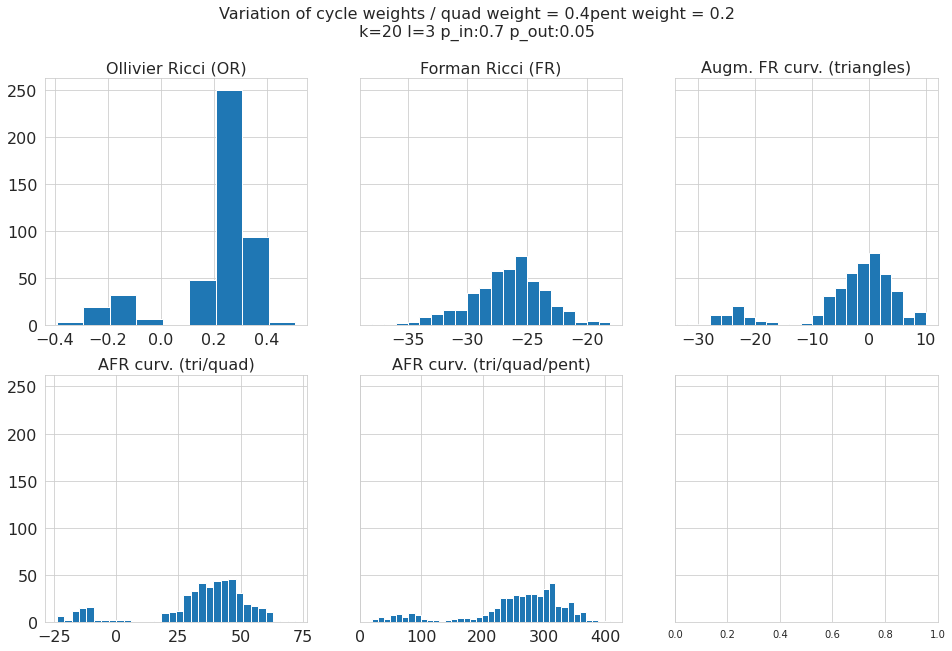


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10367
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94758
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.92904
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.87199

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06551
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.16289
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.32069

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.95298
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.87208

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.97742


k: 20  l: 3  p_in: 0.7  p_out: 0.05
Zyklen:  226341  - Zeit:  18.459867756999984

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4354
frc      Min:  -38.0000    Max:  -18.0000
afrc     Min:  -32.0000    Max:    9.0000
afrc4    Min:  -20.0000    Max:  131.2000
afrc5    Min:   63.0000    Max:  798.6000


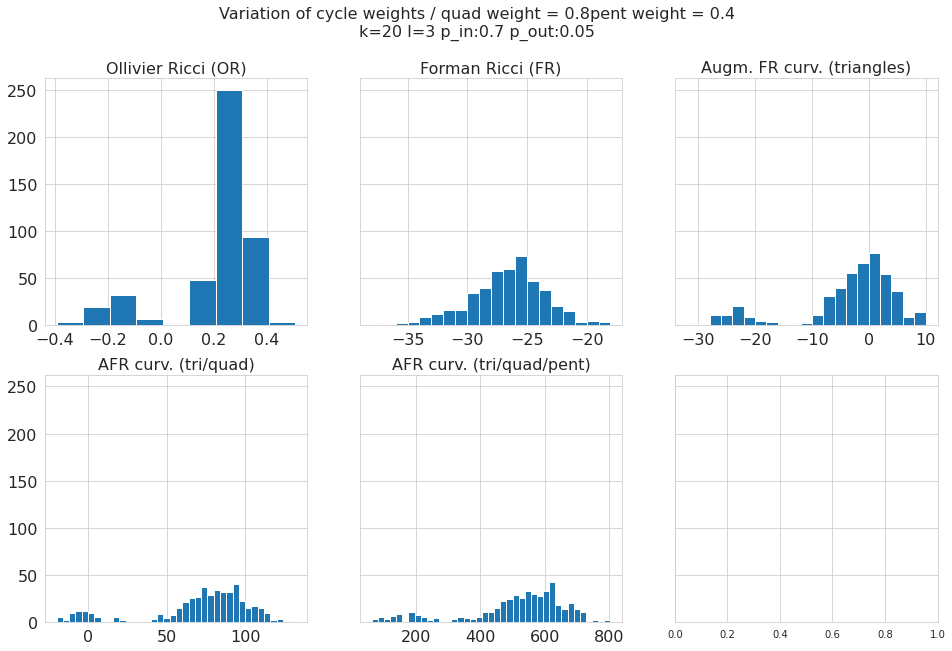


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10367
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94758
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.90941
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.86106

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06551
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.22121
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.34012

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.92538
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.85818

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.98617


k: 20  l: 3  p_in: 0.7  p_out: 0.05
Zyklen:  226341  - Zeit:  18.49014876199999

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4354
frc      Min:  -38.0000    Max:  -18.0000
afrc     Min:  -32.0000    Max:    9.0000
afrc4    Min:  -16.6000    Max:  192.8000
afrc5    Min:  107.0000    Max:  1197.4000


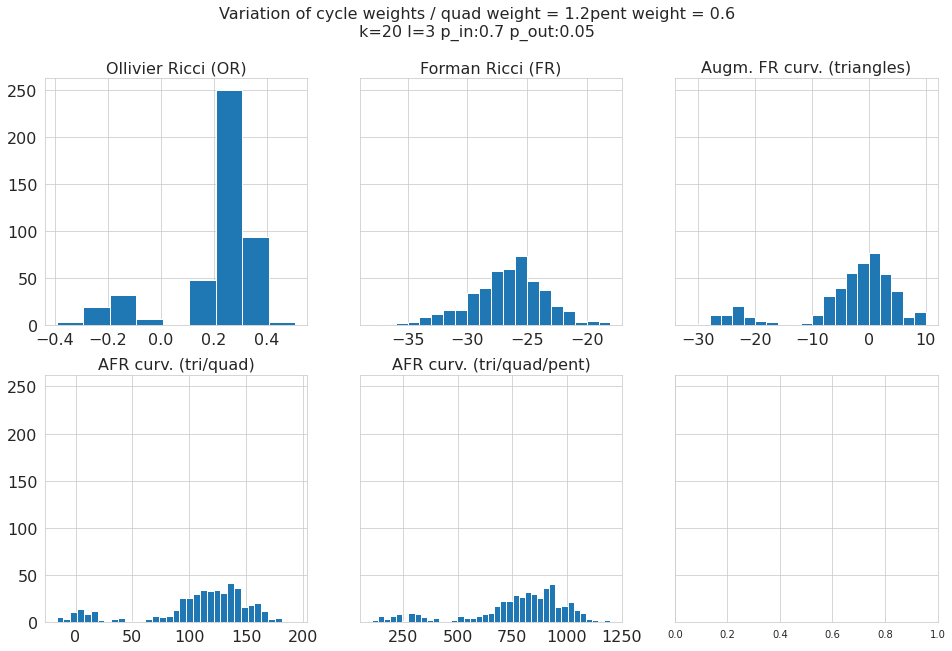


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10367
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94758
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.89854
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.85702

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06551
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.24720
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.34696

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.91086
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.85309

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.98956


k: 20  l: 3  p_in: 0.7  p_out: 0.05
Zyklen:  226341  - Zeit:  19.65968923100013

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4354
frc      Min:  -38.0000    Max:  -18.0000
afrc     Min:  -32.0000    Max:    9.0000
afrc4    Min:  -13.8000    Max:  254.4000
afrc5    Min:  151.0000    Max:  1596.2000


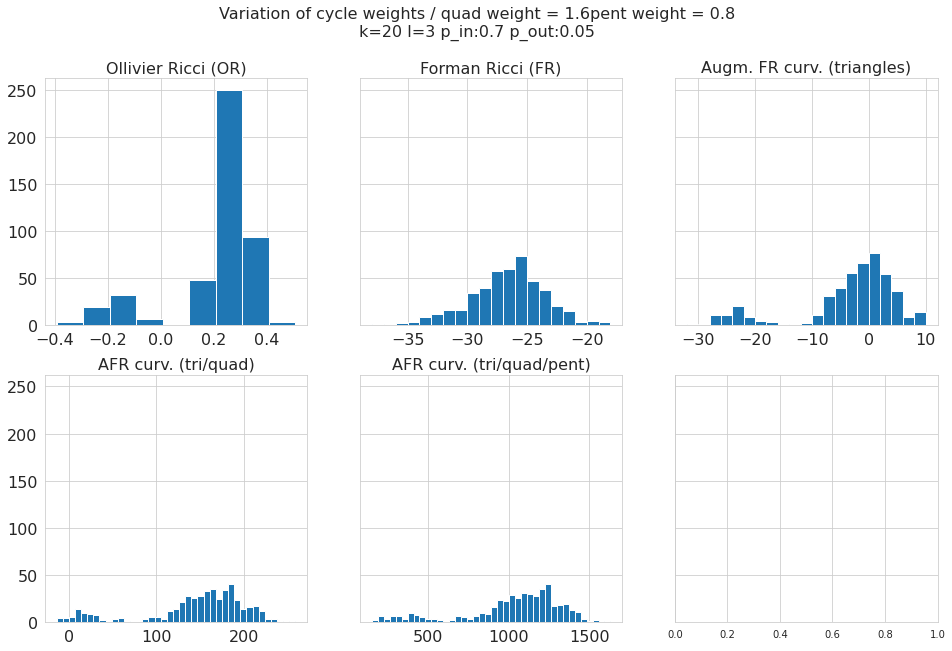


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10367
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94758
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.89181
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.85491

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06551
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.26186
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.35045

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.90204
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.85044

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.99123


k: 20  l: 3  p_in: 0.7  p_out: 0.05
Zyklen:  226341  - Zeit:  18.734157077999953

Min/Max Curvature values:
orc      Min:   -0.3929    Max:    0.4354
frc      Min:  -38.0000    Max:  -18.0000
afrc     Min:  -32.0000    Max:    9.0000
afrc4    Min:  -11.0000    Max:  316.0000
afrc5    Min:  195.0000    Max:  1995.0000

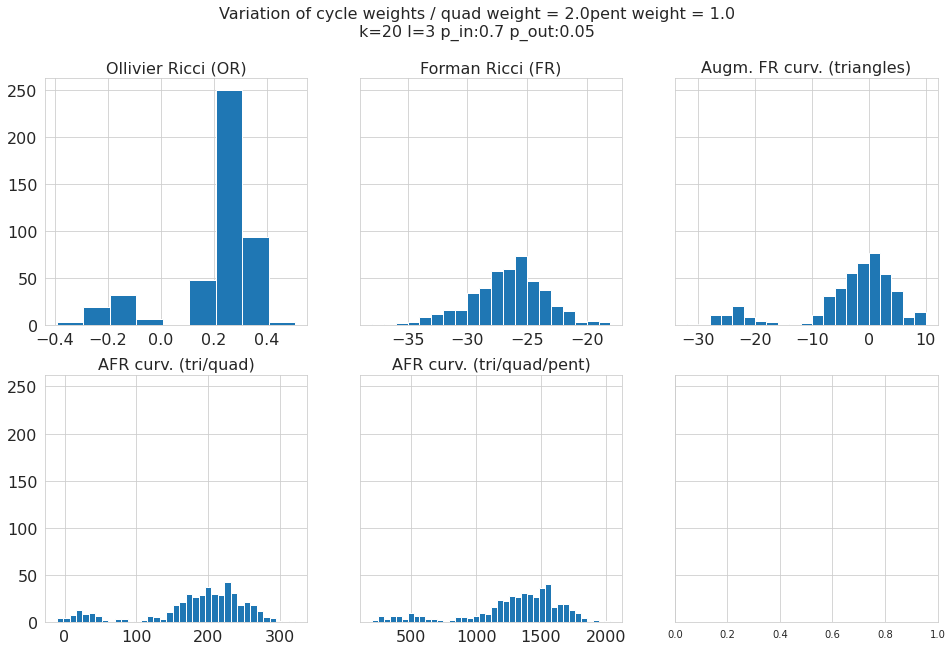


Correlation coefficients:
Ollivier Ricci (OR) / Forman Ricci (FR)................  0.10367
Ollivier Ricci (OR) / Augm. FR curv. (triangles).......  0.94758
Ollivier Ricci (OR) / AFR curv. (tri/quad).............  0.88726
Ollivier Ricci (OR) / AFR curv. (tri/quad/pent)........  0.85362

Forman Ricci (FR) / Augm. FR curv. (triangles).........  0.06551
Forman Ricci (FR) / AFR curv. (tri/quad)............... -0.27125
Forman Ricci (FR) / AFR curv. (tri/quad/pent).......... -0.35257

Augm. FR curv. (triangles) / AFR curv. (tri/quad)......  0.89614
Augm. FR curv. (triangles) / AFR curv. (tri/quad/pent).  0.84882

AFR curv. (tri/quad) / AFR curv. (tri/quad/pent).......  0.99220




In [ ]:
calculate_SBM_cycle_weight_var()